In [1]:
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
categories = ['flower', 'apple', 'baseball', 'basketball', 'bird', 'book', 'bus', 'car', 'cat', 'dog']
label_dict = {0:'flower', 1:'apple', 2:'baseball', 3:'basketball', 4:'bird',
                      5:'book',6:'bus', 7:'car', 8:'cat', 9:'dog'}
# Data Hyperparameters
test_set_split = 0.2
max_items_per_class = 5000
verbose = True
IMAGE_SIZE = 28

### Data Download

In [4]:
import urllib.request
is_download = False

if is_download:
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for idx, category in label_dict.items():
        cls_url = category.replace('_', '%20')
        path = base + cls_url+'.npy'

        if verbose:
            print(path)

        urllib.request.urlretrieve(path, raw_data_path + '/' + category +'.npy')

### Data Import and Preprocessing

In [3]:
raw_data_path = '../data/raw_data'
is_write = False

data = pd.DataFrame()

for idx, category in label_dict.items():
    if verbose:
        print (idx, category)
        
    file = raw_data_path + '/'+ category + '.npy'
    
    category_data = np.load(file)
    category_data = category_data[0:max_items_per_class, :]
    category_data = pd.DataFrame(category_data)
    category_data['label'] = idx
    
    data = pd.concat([data, category_data], axis=0, ignore_index=True)

data = data.loc[np.random.permutation(data.shape[0]), :]

if is_write:
    data.to_csv(raw_data_path + '/cnn_data.csv')

0 flower
1 apple
2 baseball
3 basketball
4 bird
5 book
6 bus
7 car
8 cat
9 dog


In [4]:
# split data
X_train, X_test, y_train, y_test = train_test_split(
    data.iloc[:, 0:-1], data.iloc[:, -1], 
    test_size=test_set_split, random_state=0)

X_train = torch.from_numpy(np.array(X_train)).float()
X_test = torch.from_numpy(np.array(X_test)).float()
y_train = torch.from_numpy(np.array(y_train)).long()
y_test = torch.from_numpy(np.array(y_test)).long()

In [5]:
X_train.shape

torch.Size([40000, 784])

### Visualize

cat


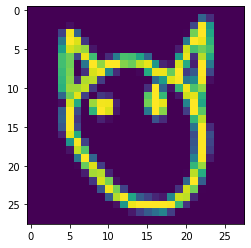

In [6]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(X_train))
plt.imshow(X_train[idx].reshape(IMAGE_SIZE,IMAGE_SIZE)) 
print (label_dict[int(y_train[idx])])

In [6]:
# Reshape and normalize
def _preprocess_X(input_data):
    input_data = input_data.reshape(input_data.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
    input_data = input_data.permute((0, 3, 1, 2))
    output = input_data / 255.
    return output

X_train = _preprocess_X(X_train)
X_test = _preprocess_X(X_test)

# Convert class vectors to class matrices
# num_classes = len(label_dict)
# y_train = F.one_hot(y_train, num_classes=num_classes)
# y_test = F.one_hot(y_test, num_classes=num_classes)

### CNN

#### Check training and evaluation functions
#### Tune params

In [7]:
# Model Hyperparameters
# input_size = 784
# hidden_sizes = [128, 100, 64]
output_size = 10

dropout = 0.0
weight_decay = 0.0
n_chunks = 500
learning_rate = 0.1
optimizer = 'SGD'

In [40]:
import time
time.time()

1650894574.6641617

In [41]:
def train(model, X_train, y_train, epochs = 10, n_chunks = 1000, learning_rate = 0.003, 
          weight_decay = 0, optimizer = 'SGD'):
    
    print("Training model with epochs = {epochs}, learning rate = {lr}\n".format(epochs = epochs, lr = learning_rate))
    criterion = nn.CrossEntropyLoss()
    
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer ==  'ADAM':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        print ("ERROR: optimizer undefined")
    
    losses = []
    res_train = []
    res_test = []
    
    res_time = [] # TODO2
    
    for epoch in range(epochs):
        print (epoch)
        start_time = time.time() # TODO2
        running_loss = 0
        images = torch.chunk(X_train, n_chunks)
        labels = torch.chunk(y_train, n_chunks)

        for i in range(len(images)):
            if (i%50 == 0):
                print ("processing ", i)
            optimizer.zero_grad()
            output = model.forward(images[i])
            loss = criterion(output, labels[i].squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
    
        losses.append(running_loss)
        print("Epoch: {}/{}... ".format(epoch + 1, epochs), "Loss: {:.4f}".format(running_loss))
        
        accuracy_train, accuracy_test = evaluate_model(model, X_train, y_train, X_test, y_test, n_samples_tested=10000000)
        res_train.append(accuracy_train)
        res_test.append(accuracy_test)
        print ("accuracy", accuracy_train, accuracy_test)
        
        time_taken = time.time() - start_time ##TODO2
        res_time.append(time_taken)##TODO2
    
    return losses, res_train, res_test, res_time##TODO2

def get_prediction_probability_distribution(model, input_data):
    with torch.no_grad():
        logits = model.forward(input_data)
    return torch.nn.functional.softmax(logits, dim=1)

def get_labels(model, input_data):
    probability_distribution = get_prediction_probability_distribution(model, input_data)
    pred_labels = torch.argmax(probability_distribution, axis=1, keepdims=True)
    return pred_labels

def evaluate_model(model, X_train, y_train, X_test, y_test, n_samples_tested = 5000):
    train_pred_labels = get_labels(model, X_train[:n_samples_tested])
    test_pred_labels = get_labels(model, X_test[:n_samples_tested])

    accuracy_train = accuracy_score(y_train[:n_samples_tested], train_pred_labels)
    accuracy_test = accuracy_score(y_test[:n_samples_tested], test_pred_labels)

    print("Accuracy score for train set is {} \n".format(accuracy_train))
    print("Accuracy score for test set is {} \n".format(accuracy_test))

    return accuracy_train, accuracy_test

In [43]:
model = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0)),
          ('relu2', nn.ReLU()),
          ('maxpool1', nn.MaxPool2d(2, stride=None)),
    
          ('conv3', nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)),
          ('relu3', nn.ReLU()),
          ('conv4', nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)),
          ('relu4', nn.ReLU()),
          ('maxpool2', nn.MaxPool2d(2, stride=None)),
    
          ('conv5', nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=0)),
          ('relu5', nn.ReLU()),
          ('conv6', nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=0)),
          ('relu6', nn.ReLU()),
          ('maxpool2', nn.MaxPool2d(2, stride=None)),
    
          ('dropout', nn.Dropout(0.1)),
          ('flatten', nn.Flatten()),
          ('fc1', nn.Linear(256, 512)),
          ('tanh', nn.Tanh()),
          ('fc2', nn.Linear(512, output_size)),
          ('relu7', nn.ReLU()), 
        ]))

In [44]:
train(model, X_train, y_train,
      learning_rate = learning_rate, weight_decay = weight_decay,
      n_chunks = n_chunks, optimizer = optimizer)

Training model with epochs = 10, learning rate = 0.1

0
processing  0
processing  50
processing  100
processing  150
processing  200
processing  250
processing  300
processing  350
processing  400
processing  450
Epoch: 1/10...  Loss: 1151.3200


KeyboardInterrupt: 

In [ ]:
accuracy_train, accuracy_test = evaluate_model(model, X_train, y_train, X_test, y_test, n_samples_tested = 5000)

### Resnet
#### Pretrained models work only for 3 channels. Retrain for 1 channel here. Investigate. 

In [9]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
# alexnet = models.alexnet(pretrained=True)
# squeezenet = models.squeezenet1_0(pretrained=True)
# vgg16 = models.vgg16(pretrained=True)
# densenet = models.densenet161(pretrained=True)
# inception = models.inception_v3(pretrained=True)
# googlenet = models.googlenet(pretrained=True)
# shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
# mobilenet_v2 = models.mobilenet_v2(pretrained=True)
# mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
# mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
# resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
# wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
# mnasnet = models.mnasnet1_0(pretrained=True)
# efficientnet_b0 = models.efficientnet_b0(pretrained=True)
# efficientnet_b1 = models.efficientnet_b1(pretrained=True)
# efficientnet_b2 = models.efficientnet_b2(pretrained=True)
# efficientnet_b3 = models.efficientnet_b3(pretrained=True)
# efficientnet_b4 = models.efficientnet_b4(pretrained=True)
# efficientnet_b5 = models.efficientnet_b5(pretrained=True)
# efficientnet_b6 = models.efficientnet_b6(pretrained=True)
# efficientnet_b7 = models.efficientnet_b7(pretrained=True)
# regnet_y_400mf = models.regnet_y_400mf(pretrained=True)
# regnet_y_800mf = models.regnet_y_800mf(pretrained=True)
# regnet_y_1_6gf = models.regnet_y_1_6gf(pretrained=True)
# regnet_y_3_2gf = models.regnet_y_3_2gf(pretrained=True)
# regnet_y_8gf = models.regnet_y_8gf(pretrained=True)
# regnet_y_16gf = models.regnet_y_16gf(pretrained=True)
# regnet_y_32gf = models.regnet_y_32gf(pretrained=True)
# regnet_x_400mf = models.regnet_x_400mf(pretrained=True)
# regnet_x_800mf = models.regnet_x_800mf(pretrained=True)
# regnet_x_1_6gf = models.regnet_x_1_6gf(pretrained=True)
# regnet_x_3_2gf = models.regnet_x_3_2gf(pretrained=True)
# regnet_x_8gf = models.regnet_x_8gf(pretrained=True)
# regnet_x_16gf = models.regnet_x_16gf(pretrainedTrue)
# regnet_x_32gf = models.regnet_x_32gf(pretrained=True)
# vit_b_16 = models.vit_b_16(pretrained=True)
# vit_b_32 = models.vit_b_32(pretrained=True)
# vit_l_16 = models.vit_l_16(pretrained=True)
# vit_l_32 = models.vit_l_32(pretrained=True)
# convnext_tiny = models.convnext_tiny(pretrained=True)
# convnext_small = models.convnext_small(pretrained=True)
# convnext_base = models.convnext_base(pretrained=True)
# convnext_large = models.convnext_large(pretrained=True)

In [27]:
# resnet18.state_dict().keys()

In [36]:
## TODO4
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False)
resnet18.fc = nn.Linear(in_features=512, out_features=10, bias=True)
resnet18 = resnet18.eval()
#model.train()

In [42]:
train(resnet18, X_train, y_train,
      learning_rate = learning_rate, weight_decay = weight_decay,
      n_chunks = n_chunks, optimizer="SGD")

Training model with epochs = 10, learning rate = 0.1

0
processing  0


KeyboardInterrupt: 

In [77]:
evaluate_model(resnet18, X_train, y_train, X_test, y_test, n_samples_tested = 5)

Accuracy score for train set is 0.2 

Accuracy score for test set is 0.0 



(0.2, 0.0)

In [78]:
model=resnet18
input_data= X_train[:5]
with torch.no_grad():
    logits = model.forward(input_data)
probability_distribution =  torch.nn.functional.softmax(logits, dim=1)
N = len(probability_distribution)
pred_labels = torch.argmax(probability_distribution, axis=1, keepdims=True)

In [79]:
accuracy_score(y_train[:5], pred_labels)

0.2

tensor([1, 4, 2,  ..., 2, 2, 3])